# ScaNN
---
## Download Dataset
---

In [1]:
%pip install numpy h5py requests scann

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import libraries
import numpy as np
import h5py
import os
import requests
import tempfile
import time

import scann

2023-10-15 10:34:28.623961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 10:34:28.987752: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 10:34:28.990663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 10:34:31.066667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
with tempfile.TemporaryDirectory() as tmp:
    response = requests.get("http://ann-benchmarks.com/sift-128-euclidean.hdf5")
    loc = os.path.join(tmp, "sift.hdf5")
    with open(loc, 'wb') as f:
        f.write(response.content)
    
    sift_h5py = h5py.File(loc, "r")

In [4]:
list(sift_h5py.keys())

['distances', 'neighbors', 'test', 'train']

In [5]:
dataset = sift_h5py['train']
queries = sift_h5py['test']
print(dataset.shape)
print(queries.shape)

(1000000, 128)
(10000, 128)


## Create a ScaNN Searcher
--- 

In [6]:
normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
searcher = scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product").tree(
    num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2023-10-15 10:35:37.754486: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 249544
2023-10-15 10:35:45.206057: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 7.451508895s.


In [7]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

## ScaNN interface features
---

In [8]:
# this will search the top 100 of the 2000 leaves, and compute
# the exact dot products of the top 100 candidates from asymmetric
# hashing to get the final top 10 candidates.
start = time.time()
neighbors, distances = searcher.search_batched(queries)
end = time.time()

# we are given top 100 neighbors in the ground truth, so select top 10
print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
print("Time:", end - start)

Recall: 0.98078
Time: 1.3162403106689453


In [9]:
import matplotlib.pyplot as plt

Leaves to search: 0
Recall: 0.98078
Time: 2.7177155017852783
Leaves to search: 100
Recall: 0.98078
Time: 2.4165351390838623
Leaves to search: 200
Recall: 0.98695
Time: 3.5629208087921143
Leaves to search: 300
Recall: 0.98786
Time: 2.7136073112487793
Leaves to search: 400
Recall: 0.98793
Time: 3.447558879852295
Leaves to search: 500
Recall: 0.988
Time: 4.089169502258301
Leaves to search: 600
Recall: 0.988
Time: 4.867035627365112
Leaves to search: 700
Recall: 0.98801
Time: 5.491041660308838
Leaves to search: 800
Recall: 0.98801
Time: 6.307891130447388
Leaves to search: 900
Recall: 0.98801
Time: 6.904674053192139
Leaves to search: 1000
Recall: 0.98801
Time: 7.792321443557739


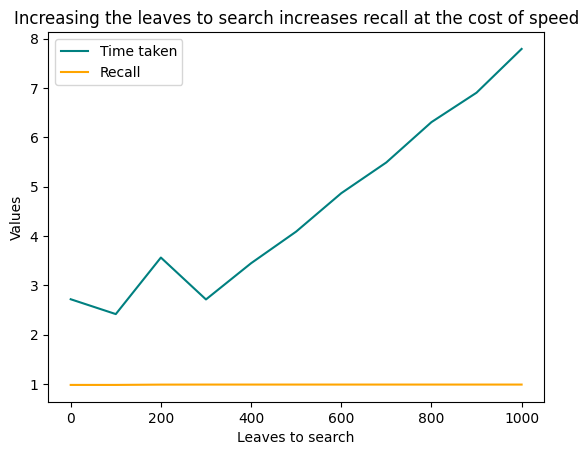

In [11]:
# increasing the leaves to search increases recall at the cost of speed
leaves = range(0, 1001, 100)
times = []
recalls = []
for leaf in leaves:
    print("Leaves to search:", leaf)
    start = time.time()
    neighbors, distances = searcher.search_batched(queries, leaves_to_search=leaf)
    end = time.time()

    print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    recalls.append(compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    print("Time:", end - start)
    times.append(end - start)

plt.plot(leaves, times, color='teal', label='Time taken')
plt.plot(leaves, recalls, color='orange', label='Recall')
plt.legend()
plt.xlabel('Leaves to search')
plt.ylabel('Values')
plt.title('Increasing the leaves to search increases recall at the cost of speed')
plt.show()

Pre-Reorder: 100
Recall: 0.98533
Time: 3.5190353393554688
Pre-Reorder: 200
Recall: 0.98912
Time: 3.643462896347046
Pre-Reorder: 300
Recall: 0.98947
Time: 2.480299949645996
Pre-Reorder: 400
Recall: 0.98952
Time: 2.3297793865203857
Pre-Reorder: 500
Recall: 0.98953
Time: 2.537214756011963
Pre-Reorder: 600
Recall: 0.98954
Time: 2.805518388748169
Pre-Reorder: 700
Recall: 0.98954
Time: 3.165976047515869
Pre-Reorder: 800
Recall: 0.98954
Time: 3.080214738845825
Pre-Reorder: 900
Recall: 0.98954
Time: 3.2937896251678467
Pre-Reorder: 1000
Recall: 0.98954
Time: 3.4153454303741455


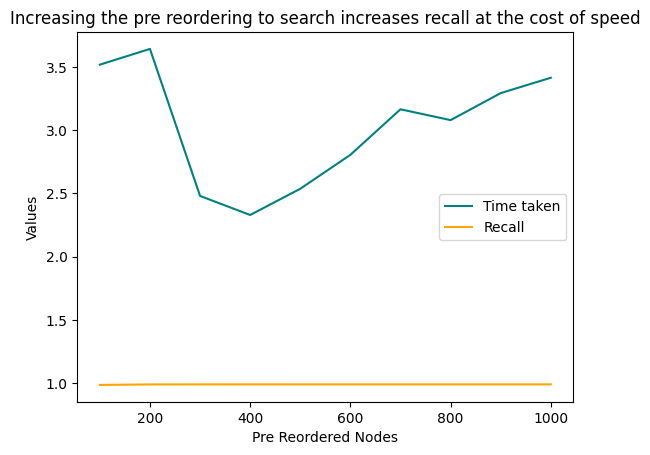

In [14]:
# increasing reordering (the exact scoring of top AH candidates) has a similar effect.
pre_reorder = range(100, 1001, 100)
times = []
recalls = []
for pr in pre_reorder:
    print("Pre-Reorder:", pr)
    start = time.time()
    neighbors, distances = searcher.search_batched(queries, leaves_to_search=150, pre_reorder_num_neighbors=pr)
    end = time.time()

    print("Recall:", compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    recalls.append(compute_recall(neighbors, sift_h5py['neighbors'][:, :10]))
    print("Time:", end - start)
    times.append(end - start)

plt.plot(pre_reorder, times, color='teal', label='Time taken')
plt.plot(pre_reorder, recalls, color='orange', label='Recall')
plt.legend()
plt.xlabel('Pre Reordered Nodes')
plt.ylabel('Values')
plt.title('Increasing the pre reordering to search increases recall at the cost of speed')
plt.show()

In [14]:
# we can also dynamically configure the number of neighbors returned
# currently returns 10 as configued in ScannBuilder()
neighbors, distances = searcher.search_batched(queries)
print(neighbors.shape, distances.shape)

# now returns 20
neighbors, distances = searcher.search_batched(queries, final_num_neighbors=20)
print(neighbors.shape, distances.shape)

(10000, 10) (10000, 10)
(10000, 20) (10000, 20)


[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 1.1944770812988281
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 1.3914108276367188
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.4875659942626953
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.33473968505859375
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.4668235778808594
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.31304359436035156
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.49114227294921875
[932085 934876 561813 708177 706771]
[454.80237 453.99243 449.59064 443.9261  443.51404]
Latency (ms): 0.33354759216308594
[932085 934876 56181

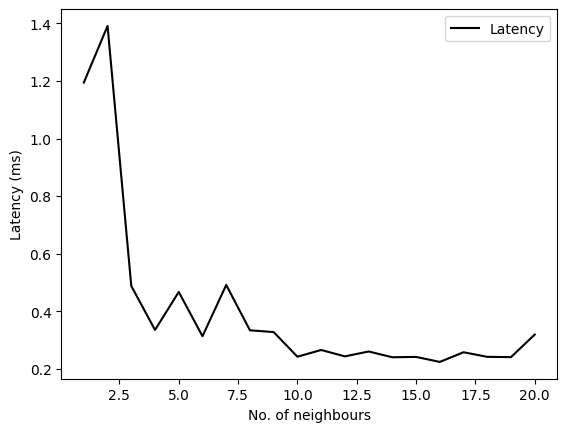

In [17]:
# we have been exclusively calling batch search so far; the single-query call has the same API
neighbor = range(1, 21)
latencies = []
for nn in neighbor:
    start = time.time()
    neighbors, distances = searcher.search(queries[0], final_num_neighbors=5)
    end = time.time()

    print(neighbors)
    print(distances)
    print("Latency (ms):", 1000*(end - start))
    latencies.append(1000*(end - start))

plt.plot(neighbor, latencies, color='black', label='Latency')
plt.legend()
plt.xlabel('No. of neighbours')
plt.ylabel('Latency (ms)')
plt.legend()
plt.show()